# Initial Report for Sample SCAF4331_24008101_A1_VHD

### Caveats:
This is a preliminary analysis conducted to provide initial insights into the data. The final report will be significantly more refined and include additional steps such as batch adjustments, compression testing, and cell type prediction, none of which are performed here. Only a single sample was analyzed.

---
### Quality Control (QC)
The first step in the analysis focused on evaluating the quality of the data. Gene expression distributions were inspected, and thresholds were applied to remove low-quality cells and outliers. Cells with unusually low or high RNA content were filtered out to avoid introducing noise into the downstream analysis. Similarly, genes expressed in only a small number of cells were excluded to ensure robust results.

---
### Clustering
Cell clustering was performed to group cells with similar transcriptional profiles. Dimensionality reduction was carried out using PCA to simplify the dataset while preserving its key features. A k-nearest neighbor (kNN) graph was constructed to capture the relationships between cells. Clusters were then identified using the Leiden or Louvain clustering algorithms, revealing distinct populations of cells within the sample.

To integrate spatial information, the SpatialLeiden algorithm was used. This method combines the gene expression embedding space with the spatial location of cells, providing a more comprehensive clustering analysis that accounts for both molecular and spatial contexts.

---
## Gene Enrichment
Marker genes for each identified cluster were investigated through differential expression analysis. These marker genes were used to explore potential functional enrichment, providing preliminary insights into the biological roles of the clusters. This step lays the groundwork for a more detailed functional characterization in future analyses.

---

## Neighborhood Analysis
The spatial relationships among the clusters were explored to understand their spatial organization and interactions. A spatial neighbors graph was computed, and the spatial patterns of clusters were visualized to assess their proximity and potential inter-cluster communication. This analysis provides an intuitive understanding of the spatial structure within the tissue.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
from cupyx.scipy.sparse import csr_matrix 
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
import pickle
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict

In [3]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_dist
from rsc_functions.utility.rank_genes_groups import return_markers,rank_genes_groups
from rsc_functions.reports.plot import plot_expression

In [5]:
path_008 = "/data/kanferg/Sptial_Omics/projects/NatalieLab/liver_cancer/data/CS037374_Set01/outs/binned_outputs/square_008um"
pathout = "/data/kanferg/Sptial_Omics/projects/NatalieLab/liver_cancer/spatialomicstoolkit/out_1"

In [4]:
def parquet_to_csv(path):
    '''
    Converts a Parquet file to a CSV file if the CSV file does not already exist.
    '''
    file_path = os.path.join(path,'spatial/tissue_positions_list.csv')
    if not os.path.exists(file_path):
        df = pd.read_parquet(os.path.join(path,'spatial/tissue_positions.parquet'))
        # Write to a CSV file
        df.to_csv(os.path.join(path,'spatial/tissue_positions_list.csv'), index=False)
    return
parquet_to_csv(path_008)

In [16]:
warnings.simplefilter("ignore", pd.errors.DtypeWarning)
andata = sc.read_visium(path=path_008)
rsc.get.anndata_to_GPU(andata)
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.var_names_make_unique()
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="MT-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])

<center> <h4>QC</h4> 

To assess the quality of the data, we examined several key metrics: the sum of gene expression per cell, the number of genes expressed per cell, and the distribution of cells per gene. 

The plots revealed a small peak at the lower end of the distribution, which may correspond to low-quality cells. Additionally, a few outliers with unusually high values were observed. These outliers could potentially influence downstream analyses, such as clustering and marker gene detec

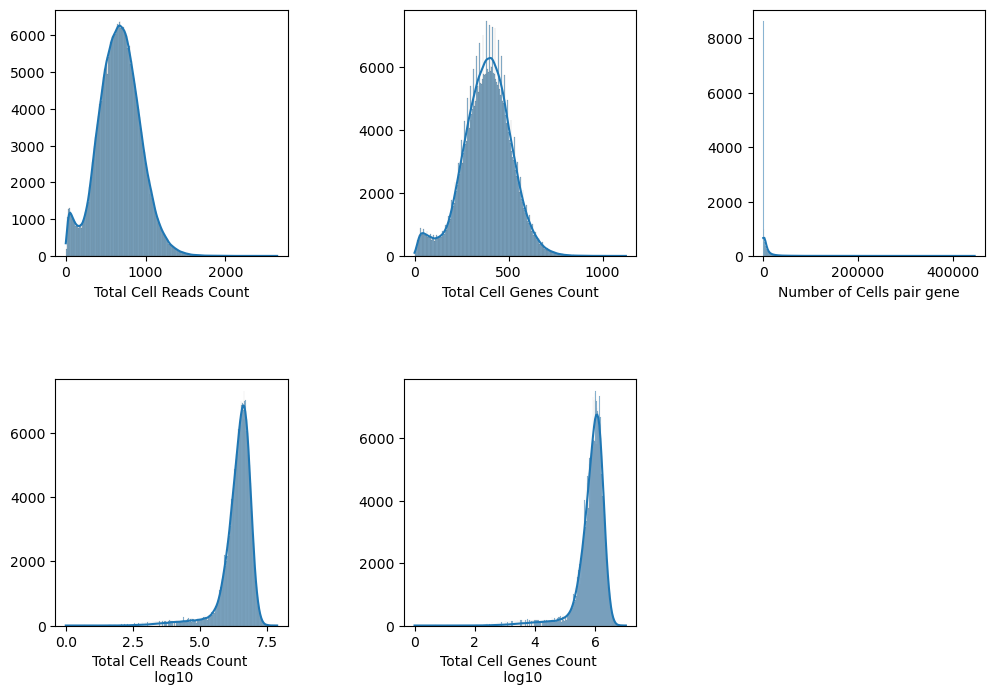

In [12]:
import warnings
# Suppress warnings in this specific code chunk
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax = np.ravel(ax)
    plot_dist(andata,column = 'total_counts',ax = ax[0],xlab = 'Total Cell Reads Count')
    plot_dist(andata,column = 'n_genes_by_counts',ax = ax[1],xlab = 'Total Cell Genes Count')
    plot_dist(andata,column = 'n_cells_by_counts',bins = 'doane', type = 'var', ax = ax[2],xlab = 'Number of Cells pair gene')
    plot_dist(andata,column = 'log1p_total_counts',ax = ax[3],xlab = 'Total Cell Reads Count \n log10')
    plot_dist(andata,column = 'log1p_n_genes_by_counts',ax = ax[4],xlab = 'Total Cell Genes Count \n log10')
    ax[5].axis('off')
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)

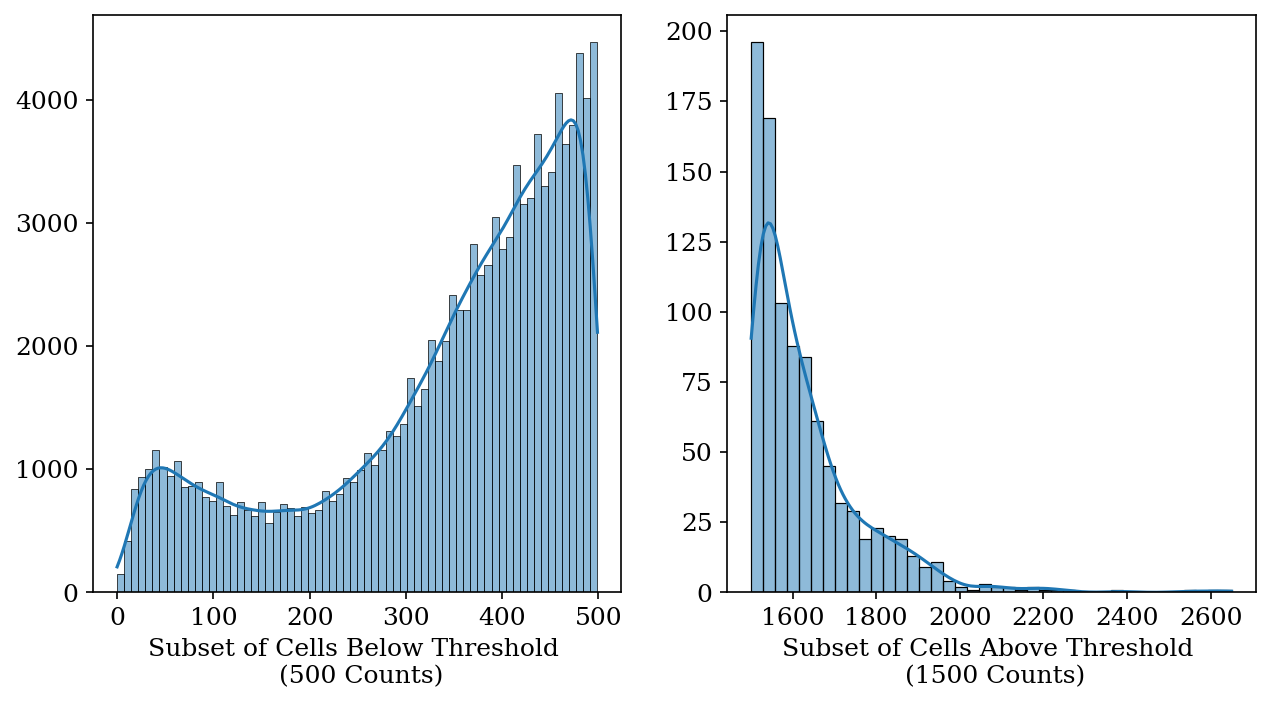

In [13]:
warnings.simplefilter("ignore")
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
andata_filetr = andata[andata.obs["total_counts"] < 500,:].copy() 
plot_dist(andata_filetr,column = 'total_counts',ax = ax[0],xlab = 'Subset of Cells Below Threshold \n (500 Counts)')
del andata_filetr
andata_filetr = andata[andata.obs["total_counts"] > 1500,:].copy() 
plot_dist(andata_filetr,column = 'total_counts',ax = ax[1],xlab = 'Subset of Cells Above Threshold \n (1500 Counts)')
del andata_filetr

The plots revealed a small peak at the lower end of the distribution, which may correspond to low-quality cells. Additionally, a few outliers with unusually high values were observed. These outliers could potentially influence downstream analyses, such as clustering and marker gene detection, and should be carefully evaluated for their impact.

In [17]:
rsc.pp.filter_cells(andata, min_count=150,qc_var = 'total_counts')

filtered out 16202 cells


In [18]:
rsc.pp.filter_genes(andata, max_count=50_000)

filtered out 669 genes based on n_cells_by_counts


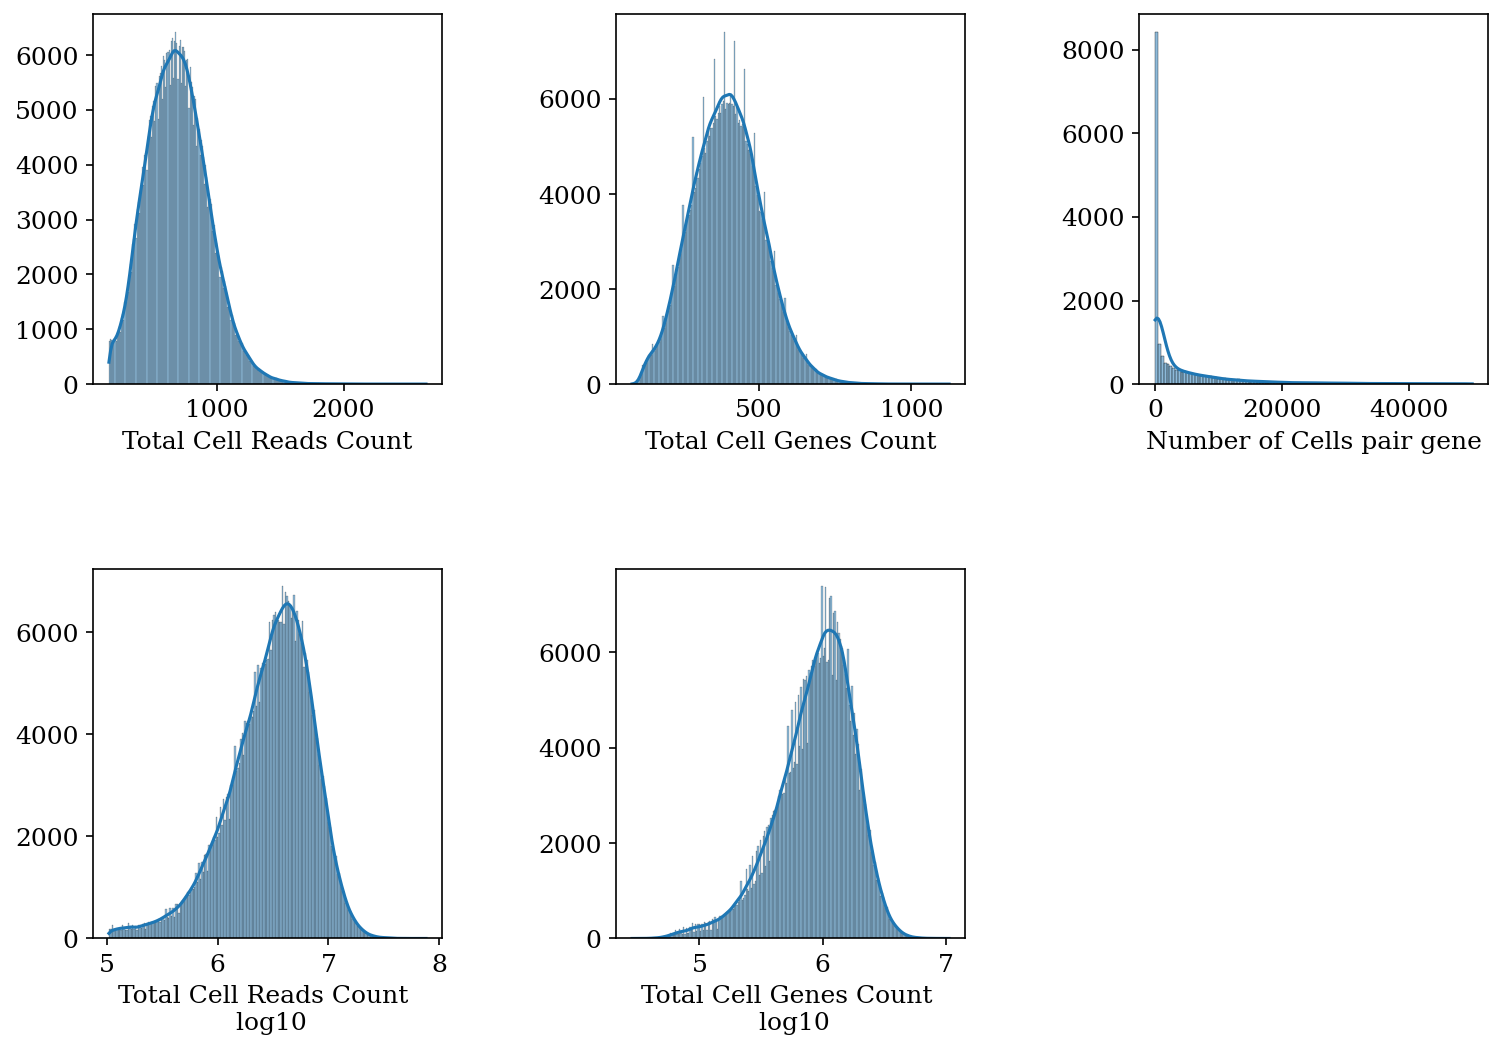

In [19]:
import warnings
# Suppress warnings in this specific code chunk
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    ax = np.ravel(ax)
    plot_dist(andata,column = 'total_counts',ax = ax[0],xlab = 'Total Cell Reads Count')
    plot_dist(andata,column = 'n_genes_by_counts',ax = ax[1],xlab = 'Total Cell Genes Count')
    plot_dist(andata,column = 'n_cells_by_counts',bins = 'doane', type = 'var', ax = ax[2],xlab = 'Number of Cells pair gene')
    plot_dist(andata,column = 'log1p_total_counts',ax = ax[3],xlab = 'Total Cell Reads Count \n log10')
    plot_dist(andata,column = 'log1p_n_genes_by_counts',ax = ax[4],xlab = 'Total Cell Genes Count \n log10')
    ax[5].axis('off')
    plt.subplots_adjust(wspace = 0.5, hspace=0.5)

<center><h4>Clustering

In [7]:
def plot_spatial(andata,ax, cluster = 'cluster', features = None,title = '',xlab = '',ylab ='',size = 2,alpha = 0.6, markerscale = 5, cluster_name = 'cluster'):
    palette = sns.color_palette("tab20") + sns.color_palette("tab20b") + sns.color_palette("tab20c")
    df = pd.DataFrame({'cluster':andata.obs[cluster],'x':andata.obsm['spatial'][:,0],'y':andata.obsm['spatial'][:,1]})
    if features:
        df[df['cluster'].isin([features])]
    num_classes = len(df['cluster'].unique())
    if num_classes==1:
        listed_cmap = ListedColormap(palette)
    else:
        num_classes = len(np.unique(df['cluster'].values))
        extended_palette = palette * (num_classes // len(palette) + 1)
        extended_palette = extended_palette[:num_classes]
        listed_cmap = ListedColormap(extended_palette)
    color_container = []
    
    clusters = sorted(np.unique(df['cluster'].values), key=int)
    for i, cluster in enumerate(clusters):
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter( x=cluster_data['x'], y=cluster_data['y'], color=listed_cmap(i), label=f'{cluster}', s=size, alpha=alpha)
        color_container.append(listed_cmap(i))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    legend = ax.legend( title=cluster_name,
                        bbox_to_anchor=(1.05, 1),  # Position the legend outside the plot
                        loc='upper left',
                        fontsize='small',  # Control the font size
                        title_fontsize='medium',
                        markerscale=markerscale,  # Increase the size of the legend markers
                        frameon=False# Control the title font size
                        )
    df_color = pd.DataFrame({"clusters":df['cluster'].unique(),"colors":color_container})
    return df_color

In [6]:
andata = sc.read_h5ad(os.path.join(pathout, "andata_filter_logNorm_hvg_spatialleiden.h5ad"))
andata

AnnData object with n_obs × n_vars = 431525 × 5000
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cluster', 'spatialleiden'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial_neighbors'
    obsm: 'X_pca', 'spatial'
    layers: 'counts', 'log'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

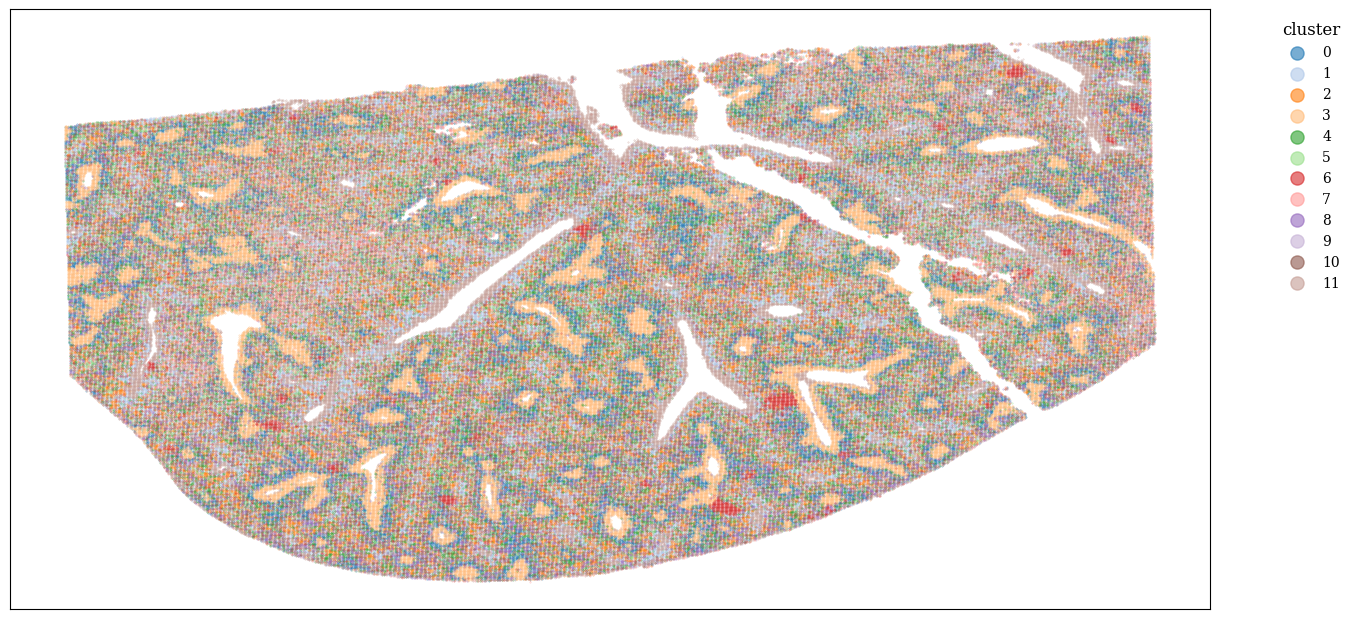

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
plt.rcParams['figure.dpi'] = 800
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
clusterColorMap = plot_spatial(andata,ax = ax,cluster = 'spatialleiden', features = None, title = '',markerscale = 30, xlab = '',ylab ='',size = 0.1)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.5)

<center>Gene Enrichment</center>
Marker genes for each identified cluster were investigated through differential expression analysis. These marker genes were used to explore potential functional enrichment, providing preliminary insights into the biological roles of the clusters. This step lays the groundwork for a more detailed functional characterization in future analyses.

In [9]:
andata.X = andata.layers['log'].copy()
rsc.get.anndata_to_CPU(andata)
sc.tl.rank_genes_groups(andata, groupby="spatialleiden", method="wilcoxon")
andata.obs['spatialleiden'] = andata.obs['spatialleiden'].astype(str)

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sc.pl.rank_genes_groups_dotplot(andata, groupby="spatialleiden",n_genes=2,values_to_plot = 'scores',ax =ax)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

<Figure size 588.8x441.6 with 0 Axes>

<center>Neighborhood Analysis</center>
The spatial relationships among the clusters were explored to understand their spatial organization and interactions. A spatial neighbors graph was computed, and the spatial patterns of clusters were visualized to assess their proximity and potential inter-cluster communication. This analysis provides an intuitive understanding of the spatial structure within the tissue.

In [11]:
import squidpy as sq
sq.gr.nhood_enrichment(andata, cluster_key="spatialleiden")

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.83/s]


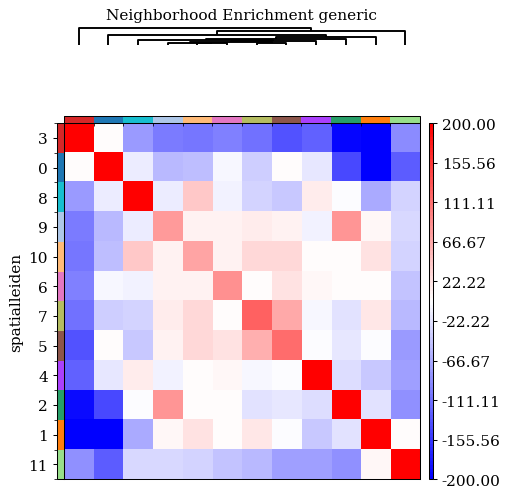

In [15]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
n_bins = 100  # Discretize into 100 bins
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

plt.rcParams['figure.dpi'] = 92
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sq.pl.nhood_enrichment(
    andata,
    title = "Neighborhood Enrichment generic",
    cluster_key="spatialleiden",
    method="average",
    cmap=custom_cmap,
    vmin=-200,
    vmax=200,
    figsize=(5, 5),
)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

The gene enrichment analysis did not detect strongly differential gene expression in cluster 7 compared to other clusters. The neighborhood analysis revealed that clusters 5 and 7 are associated in both gene expression levels and spatial organization. 
To improve accuracy, these clusters may need to be merged, followed by recalculating the gene enrichment analysis. Re-merging these clusters could provide a more robust understanding of the underlying biological patterns.